<a href="https://colab.research.google.com/github/MykhailoMatsyshyn/Neural-Networks-Labs/blob/main/LR1_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Варіант 1**
*Класифікація послідовностей, наприклад фраз, на дві категорії (наприклад, spam/ham чи позитив/негатив).*

### **Дані**
•	Використати датасет Spam Emails або SMS Spam.

### **Реалізація**

•	Токенізація: простий split або стандартний BPE токенайзер HuggingFace.

•	Архітектура моделі: Embedding + позиційне кодування + 1–2 шари TransformerEncoderLayer + Linear для класифікації.

•	Додати training loop.

•	Метрики: accuracy, precision, recall, F1-score.

•	Збереження моделі у файл.

•	Балансування класів.

•	Тюнінг гіперпараметрів (nhead, d_model).


##**Встановлення бібліотек**

In [46]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoTokenizer
# import math

import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import torch.nn.functional as F

## **Завантаження та аналіз датасету**

###--- 1. Завантаження та підготовка даних ---

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [7]:
df.head(16).style

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",nan,nan,nan
1,ham,Ok lar... Joking wif u oni...,nan,nan,nan
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,nan,nan,nan
3,ham,U dun say so early hor... U c already then say...,nan,nan,nan
4,ham,"Nah I don't think he goes to usf, he lives around here though",nan,nan,nan
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",nan,nan,nan
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,nan,nan,nan
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,nan,nan,nan
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,nan,nan,nan
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,nan,nan,nan


In [8]:
# Перейменування колонок та видалення зайвих
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df = df[['label', 'text']]

In [10]:
df.head(16).style

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [11]:
# Кодування міток: 'ham' (не спам) -> 0, 'spam' -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [12]:
df.head(16).style

,label,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"
5,1,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
6,0,Even my brother is not like to speak with me. They treat me like aids patent.
7,0,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,1,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,1,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [13]:
# Розділення на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [14]:
print(f"Розмір навчального набору: {len(X_train)}")
print(f"Розмір тестового набору: {len(X_test)}")
print("-" * 30)

Розмір навчального набору: 4457
Розмір тестового набору: 1115
------------------------------


###--- 2. Аналіз балансування класів ---

In [15]:
train_labels = y_train.tolist()
label_counts = Counter(train_labels)

print("Розподіл класів у навчальному наборі:")
print(f"Не спам (0): {label_counts[0]} ({label_counts[0]/len(X_train)*100:.2f}%)")
print(f"Спам (1): {label_counts[1]} ({label_counts[1]/len(X_train)*100:.2f}%)")
print("-" * 30)

Розподіл класів у навчальному наборі:
Не спам (0): 3859 (86.58%)
Спам (1): 598 (13.42%)
------------------------------


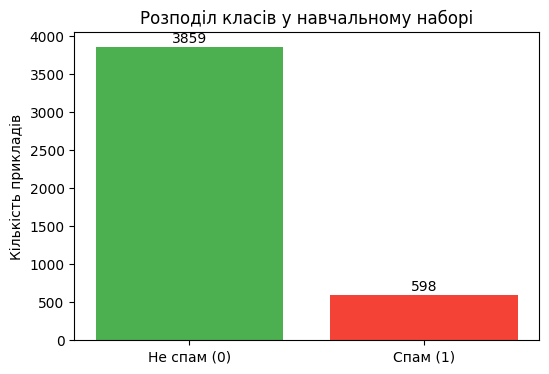

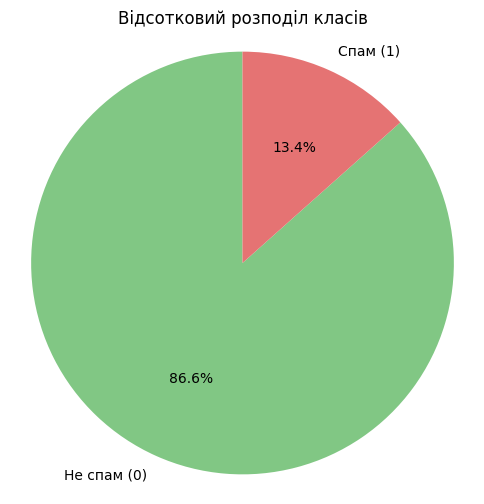

In [19]:
# --- Побудова графіків розподілу ---
classes = ['Не спам (0)', 'Спам (1)']
counts = [label_counts[0], label_counts[1]]
percentages = [c / len(X_train) * 100 for c in counts]

# Бар-чарт
plt.figure(figsize=(6,4))
bars = plt.bar(classes, counts, color=['#4CAF50', '#F44336'])
plt.title("Розподіл класів у навчальному наборі")
plt.ylabel("Кількість прикладів")
for bar, c in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, c + 10, str(c), ha='center', va='bottom')
plt.show()

# Pie-чарт
plt.figure(figsize=(6,6))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90,
        colors=['#81C784', '#E57373'])
plt.title("Відсотковий розподіл класів")
plt.axis('equal')
plt.show()

In [16]:
# Визначення ваг класів для CrossEntropyLoss (для боротьби з дисбалансом)
# Вага = (Загальна кількість / Кількість класу)
total_samples = len(X_train)
weight_0 = total_samples / label_counts[0]
weight_1 = total_samples / label_counts[1]

# Нормалізація ваг, щоб вони не були надто великими
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32)

print("Ваги класів для CrossEntropyLoss:")
print(f"Вага для 'Не спам' (0): {class_weights[0]:.4f}")
print(f"Вага для 'Спам' (1): {class_weights[1]:.4f}")

Ваги класів для CrossEntropyLoss:
Вага для 'Не спам' (0): 1.1550
Вага для 'Спам' (1): 7.4532


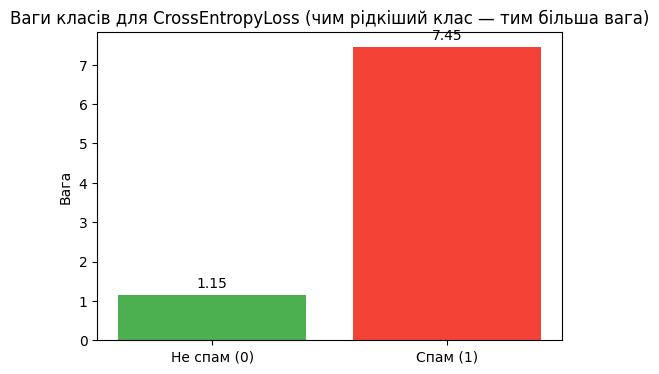

In [20]:
# --- Графіки для ваг ---
weights_df = pd.DataFrame({
    'Клас': classes,
    'Вага': [weight_0, weight_1]
})

plt.figure(figsize=(6,4))
bars = plt.bar(weights_df['Клас'], weights_df['Вага'], color=['#4CAF50', '#F44336'])
plt.title("Ваги класів для CrossEntropyLoss (чим рідкіший клас — тим більша вага)")
plt.ylabel("Вага")
for bar, w in zip(bars, weights_df['Вага']):
    plt.text(bar.get_x() + bar.get_width()/2, w + 0.1, f"{w:.2f}", ha='center', va='bottom')
plt.show()

##**Токенізація та Клас Даталоадера**

###--- Ініціалізація токенізатора ---

In [21]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
VOCAB_SIZE = tokenizer.vocab_size

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
class TextClassificationDataset(Dataset):
    """
    Клас PyTorch Dataset для токенізації текстових даних
    та підготовки їх до моделі Трансформера.
    """
    def __init__(self, texts, labels, tokenizer, max_len=64):
        # Перетворюємо об'єкти Series в списки для зручності
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Токенізація: truncation, padding, повернення PyTorch тензорів
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


### --- Створення Даталоадерів ---

In [23]:
MAX_LEN = 64
BATCH_SIZE = 32

train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Кількість батчів у навчальному лоадері: {len(train_loader)}")

Кількість батчів у навчальному лоадері: 140


### --- Аналіз ---

#### Гістограма довжин (кількість токенів до паддінгу / усічення)

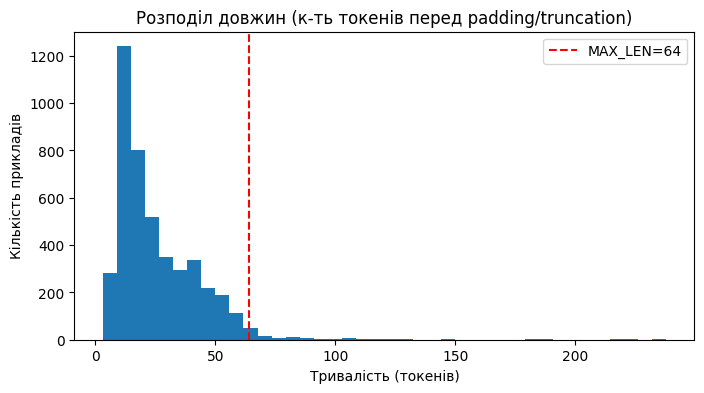

Кількість(%) усічених прикладів: 85 / 4457 = 1.91%


In [24]:
# Обчислити довжини токенів (без padding), з додаванням спец-токенів
lengths = []
for text in X_train:
    ids = tokenizer.encode(text, add_special_tokens=True)  # list of ids
    lengths.append(len(ids))

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=40)
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f"MAX_LEN={MAX_LEN}")
plt.title("Розподіл довжин (к-ть токенів перед padding/truncation)")
plt.xlabel("Тривалість (токенів)")
plt.ylabel("Кількість прикладів")
plt.legend()
plt.show()

# скільки будуть усікатися через MAX_LEN?
truncated_count = sum(1 for L in lengths if L > MAX_LEN)
print(f"Кількість(%) усічених прикладів: {truncated_count} / {len(lengths)} = {truncated_count/len(lengths)*100:.2f}%")

#### Розподіл довжин по класах

/tmp/ipython-input-3034555034.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([lengths_by_label[0], lengths_by_label[1]], labels=['Не спам (0)', 'Спам (1)'])


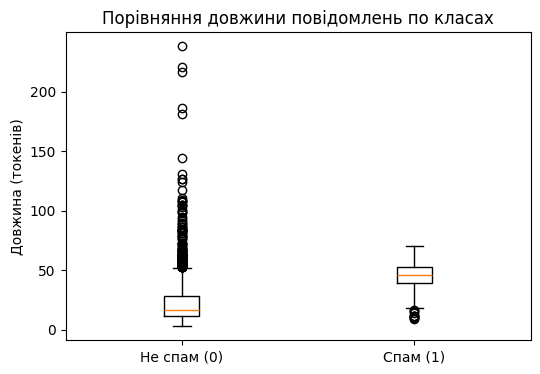

In [25]:
# lengths_by_label
lengths_by_label = {0: [], 1: []}
for text, label in zip(X_train, y_train):
    L = len(tokenizer.encode(text, add_special_tokens=True))
    lengths_by_label[label].append(L)

plt.figure(figsize=(6,4))
plt.boxplot([lengths_by_label[0], lengths_by_label[1]], labels=['Не спам (0)', 'Спам (1)'])
plt.ylabel("Довжина (токенів)")
plt.title("Порівняння довжини повідомлень по класах")
plt.show()

#### Найпоширеніші токени (без спец-токенів)

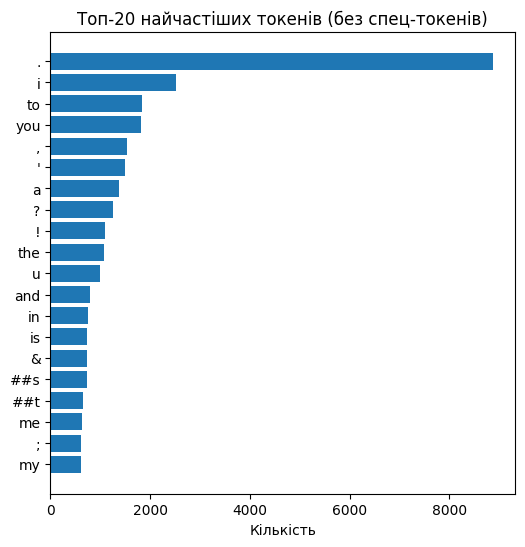

In [26]:
all_ids = []
for text in X_train:
    ids = tokenizer.encode(text, add_special_tokens=False)  # exclude [CLS]/[SEP]
    all_ids.extend(ids)

cnt = Counter(all_ids)
top20 = cnt.most_common(20)
ids_top = [i for i,_ in top20]
tokens_top = tokenizer.convert_ids_to_tokens(ids_top)
counts_top = [c for _,c in top20]

plt.figure(figsize=(6,6))
plt.barh(tokens_top[::-1], counts_top[::-1])
plt.title("Топ-20 найчастіших токенів (без спец-токенів)")
plt.xlabel("Кількість")
plt.show()

#### Приклад токенізації одного повідомлення

In [30]:
sample_text = X_train.iloc[5] if hasattr(X_train, "iloc") else list(X_train)[5]
enc = tokenizer(sample_text, truncation=True, padding=False, max_length=MAX_LEN)
print("Оригінал:\n", sample_text)
print("\nInput IDs:\n", enc['input_ids'])
print("\nTokens:\n", tokenizer.convert_ids_to_tokens(enc['input_ids']))
print("\nAttention mask:\n", enc['attention_mask'])

Оригінал:
 Hhahhaahahah rofl wtf nig was leonardo in your room or something

Input IDs:
 [101, 1044, 3270, 23644, 11057, 3270, 3270, 2232, 20996, 10258, 1059, 24475, 9152, 2290, 2001, 14720, 1999, 2115, 2282, 2030, 2242, 102]

Tokens:
 ['[CLS]', 'h', '##ha', '##hh', '##aa', '##ha', '##ha', '##h', 'ro', '##fl', 'w', '##tf', 'ni', '##g', 'was', 'leonardo', 'in', 'your', 'room', 'or', 'something', '[SEP]']

Attention mask:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [32]:
sample_text = X_train.iloc[5] if hasattr(X_train, "iloc") else list(X_train)[5]
enc = tokenizer(sample_text, truncation=True,  padding="max_length", max_length=MAX_LEN)
print("Оригінал:\n", sample_text)
print("\nInput IDs:\n", enc['input_ids'])
print("\nTokens:\n", tokenizer.convert_ids_to_tokens(enc['input_ids']))
print("\nAttention mask:\n", enc['attention_mask'])

Оригінал:
 Hhahhaahahah rofl wtf nig was leonardo in your room or something

Input IDs:
 [101, 1044, 3270, 23644, 11057, 3270, 3270, 2232, 20996, 10258, 1059, 24475, 9152, 2290, 2001, 14720, 1999, 2115, 2282, 2030, 2242, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Tokens:
 ['[CLS]', 'h', '##ha', '##hh', '##aa', '##ha', '##ha', '##h', 'ro', '##fl', 'w', '##tf', 'ni', '##g', 'was', 'leonardo', 'in', 'your', 'room', 'or', 'something', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Attention mask:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0

## **Архітектура Моделі Трансформера**

### --- Клас Позиційного Кодування ---

In [35]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        # Використання math.log для точності
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Додаємо PE до ембеддінгу
        x = x + self.pe[:, :x.size(1)]
        return x

###--- Клас Трансформера-Класифікатора ---

In [36]:
class TransformerEncoderClassifier(nn.Module):
    """
    Модель Трансформера-Енкодера для класифікації тексту.
    Використовує вихід CLS-токена для фінального передбачення.
    """
    def __init__(self, vocab_size, d_model, nhead, num_layers=2, num_classes=2, max_len=64):
        super().__init__()
        self.d_model = d_model

        # 1. Ембеддінг
        self.embedding = nn.Embedding(vocab_size, d_model)

        # 2. Позиційне Кодування
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # 3. Трансформер-Енкодер (з можливістю тюнінгу nhead та num_layers)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            # FFN розмірність часто встановлюють 4*d_model
            dim_feedforward=d_model * 4
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Фінальний лінійний шар (на основі CLS-токена)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # 1. Ембеддінг + PE
        x = self.embedding(input_ids) * math.sqrt(self.d_model) # Масштабування ембеддінгу (стандартна практика)
        x = self.positional_encoding(x)

        # 2. Підготовка маски для TransformerEncoder (True для padding)
        key_padding_mask = attention_mask == 0 if attention_mask is not None else None

        # 3. Прохід через Енкодер
        # src_key_padding_mask = маска, що вказує, які елементи Ключів (K) треба ігнорувати
        out = self.encoder(x, src_key_padding_mask=key_padding_mask)

        # 4. Вибірка виходу CLS-токена (перший токен у послідовності)
        cls_repr = out[:, 0, :]

        # 5. Класифікація
        return self.classifier(cls_repr)

##**Додавання Циклу Навчання (Training Loop) та Метрики**

###--- Допоміжна Функція для Обчислення Метрик ---

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_metrics(y_true, y_pred):
    """Обчислює та виводить ключові метрики класифікації."""
    # Обчислюємо Precision, Recall та F1-score для кожного класу
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )

    # Загальна точність (Accuracy)
    accuracy = accuracy_score(y_true, y_pred)

    print("-" * 50)
    print(f"Загальна Точність (Accuracy): {accuracy:.4f}")
    print("\nМетрики для класу 'Не спам' (0):")
    print(f"  Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1-score: {f1_score[0]:.4f}")
    print("\nМетрики для класу 'Спам' (1):")
    print(f"  Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1-score: {f1_score[1]:.4f}")
    print("-" * 50)

    # Повертаємо метрики для візуалізації
    return accuracy, precision[1], recall[1], f1_score[1]

###--- Допоміжна Функція для Обчислення Метрик ---

In [38]:
def validate_model(model, data_loader, device):
    """Виконує прохід по валідаційному/тестовому набору та обчислює метрики."""
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return evaluate_metrics(all_labels, all_preds)

###--- Цикл Навчання (training_loop) ---

In [39]:
import matplotlib.pyplot as plt
import os

def training_loop(model, train_loader, test_loader, class_weights, device, num_epochs=10, learning_rate=1e-4, model_path="best_transformer_spam_model.pt"):
    """Головний цикл навчання моделі."""

    # Встановлення налаштувань
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Class weights для CrossEntropyLoss бореться з дисбалансом
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    history = {'train_loss': [], 'val_accuracy': [], 'val_f1_spam': []}
    best_f1 = 0.0

    print("--- Початок Навчання ---")
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Оцінювання на валідаційному/тестовому наборі
        accuracy, _, _, f1_spam = validate_model(model, test_loader, device)

        history['train_loss'].append(avg_train_loss)
        history['val_accuracy'].append(accuracy)
        history['val_f1_spam'].append(f1_spam)

        print(f"Епоха {epoch}/{num_epochs}: Втрати (Loss) = {avg_train_loss:.4f}, F1-Spam = {f1_spam:.4f}")

        # Збереження кращої моделі на основі F1-score для класу 'spam'
        if f1_spam > best_f1:
            best_f1 = f1_spam
            torch.save(model.state_dict(), model_path)
            print(f"Збережено нову кращу модель з F1-score: {best_f1:.4f}")

    print("\n--- Навчання Завершено ---")
    return history

###--- Запуск Навчання ---

In [43]:
# --- Гіперпараметри для Тюнінгу ---
D_MODEL = 128    # Розмірність ембеддінгів та прихованих шарів Трансформера
NHEAD = 4        # Кількість голів уваги
NUM_LAYERS = 2   # Кількість шарів Енкодера
LR = 5e-5        # Швидкість навчання

# Вибір пристрою
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ініціалізація моделі
model = TransformerEncoderClassifier(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN
)

# --- Запуск циклу навчання ---
history = training_loop(
    model,
    train_loader,
    test_loader,
    class_weights,
    device,
    num_epochs=15,
    learning_rate=LR
)

--- Початок Навчання ---


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


--------------------------------------------------
Загальна Точність (Accuracy): 0.8798

Метрики для класу 'Не спам' (0):
  Precision: 0.9793, Recall: 0.8799, F1-score: 0.9269

Метрики для класу 'Спам' (1):
  Precision: 0.5304, Recall: 0.8792, F1-score: 0.6616
--------------------------------------------------
Епоха 1/15: Втрати (Loss) = 0.4760, F1-Spam = 0.6616
Збережено нову кращу модель з F1-score: 0.6616
--------------------------------------------------
Загальна Точність (Accuracy): 0.9489

Метрики для класу 'Не спам' (0):
  Precision: 0.9882, Recall: 0.9524, F1-score: 0.9700

Метрики для класу 'Спам' (1):
  Precision: 0.7500, Recall: 0.9262, F1-score: 0.8288
--------------------------------------------------
Епоха 2/15: Втрати (Loss) = 0.2130, F1-Spam = 0.8288
Збережено нову кращу модель з F1-score: 0.8288
--------------------------------------------------
Загальна Точність (Accuracy): 0.9561

Метрики для класу 'Не спам' (0):
  Precision: 0.9904, Recall: 0.9586, F1-score: 0.9742


###--- Візуалізація результатів ---

In [44]:
def plot_training_history(history):
    """Візуалізує історію втрат та метрик."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Графік втрат (ліва вісь Y)
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    ax1.set_xlabel('Епоха')
    ax1.set_ylabel('Втрати (Loss)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Графік метрик (права вісь Y)
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['val_accuracy'], 'r-^', label='Validation Accuracy')
    ax2.plot(epochs, history['val_f1_spam'], 'g-s', label='Validation F1 (Spam)')
    ax2.set_ylabel('Метрики', color='black')
    ax2.tick_params(axis='y')

    # Легенда
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')

    plt.title('Прогрес Навчання Трансформера')
    plt.tight_layout()
    plt.show()

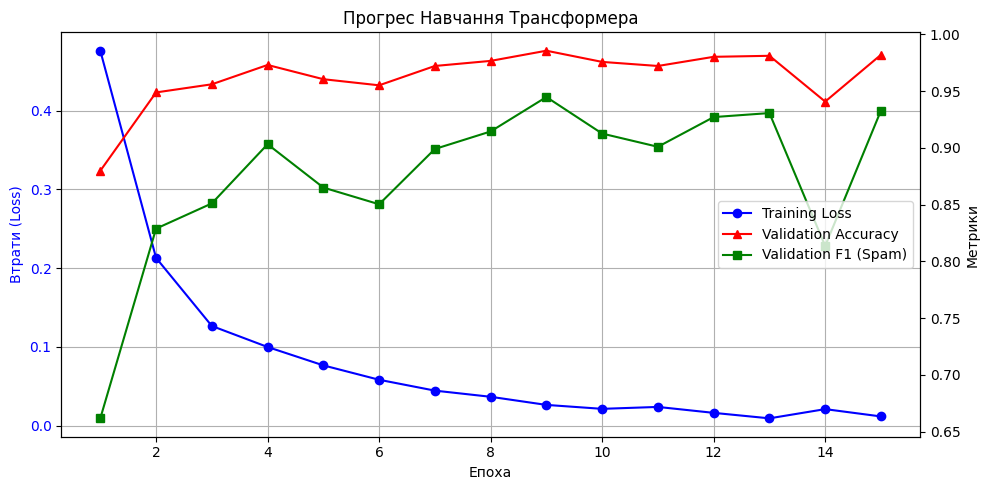

In [45]:
plot_training_history(history)

***Training Loss***

*Швидке зниження:* втрати стрімко падають з 0.4760 (Епоха 1) до менш ніж 0.05 після Епохи 6. Це свідчить про те, що модель швидко і впевнено запам'ятовує навчальний набір.

*Перенавчання (ознака 1):* з Епохи 8 і далі втрати продовжують наближатися до нуля (навіть досягають 0.0093 на Епосі 13). Це є класичною ознакою перенавчання (overfitting): модель надмірно оптимізується під навчальні дані, часто за рахунок узагальнення.

***Validation Accuracy***

*Висока точність:* точність швидко зростає до 98.57% (Епоха 9).

*Коливання:* після Епохи 9 точність починає коливатися (наприклад, різке падіння на Епосі 14 до 94.08%), але потім повертається до високих значень (98.21% на Епосі 15).

***Validation F1 (Spam)***

*Фокус на Спамі:* оскільки ми використовували ваги класів, F1-score для рідкісного класу "Спам" є найважливішим показником.

*Пік:* F1-score досягає свого найкращого значення 0.9448 на Епосі 9.

*Перенавчання (ознака 2):* після Епохи 9 F1-score для спаму також демонструє коливання та падіння (особливо на Епосі 14 до 0.8136). Це підтверджує, що модель стає менш стабільною та гірше узагальнює для критичного класу.

##**Висновки**

Отже, оптимальна продуктивність була досягнута на **Епосі 9**:

Загальна точність: **0.9857**
F1-score (Спам): **0.9448** (Найкращий показник)
Precision (Спам): **0.9716**
Recall (Спам): **0.9195**

Це означає, що 94.48% усіх передбачень спаму були точними з урахуванням балансу між хибнопозитивними та хибнонегативними спрацюваннями.

*Клас "Не Спам" (0)*

Показники для класу "Не спам" завжди дуже високі (Precision та Recall близько 0.99). Це очікувано, оскільки цей клас сильно переважає в датасеті.

*Клас "Спам" (1)*

Recall (Відгук) (наприклад, 0.9195 на Епосі 9): Модель знайшла 91.95% усіх справжніх спам-повідомлень. Це високий показник.

Precision (Точність) (наприклад, 0.9716 на Епосі 9): З усіх повідомлень, які модель позначила як "спам", 97.16% були справжнім спамом.

In [57]:
from google.colab import drive

drive.mount('/content/drive')
!cp best_transformer_spam_model.pt /content/drive/MyDrive/

Mounted at /content/drive
cp: cannot stat 'best_transformer_spam_model.pt': No such file or directory


## Приклад 1

In [47]:
class SimpleSelfAttentionWithWeights(nn.Module):
    """
    Спрощений шар Self-Attention, що повертає ваги уваги для візуалізації.
    """
    def __init__(self, d_model, nhead):
        super().__init__()
        # Припускаємо одну голову (для простоти візуалізації) або одну проекцію для Multihead
        # Для коректної візуалізації візьмемо d_model як 64, nhead=4, head_dim=16
        self.head_dim = d_model // nhead
        self.nhead = nhead

        # Проекції Q, K, V
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, key_padding_mask=None):
        B, L, D = x.size() # Batch, Sequence Length, Dim

        # 1. Проекція (Q, K, V) та поділ на голови
        Q = self.q_proj(x).view(B, L, self.nhead, self.head_dim).transpose(1, 2) # (B, H, L, H_D)
        K = self.k_proj(x).view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(B, L, self.nhead, self.head_dim).transpose(1, 2)

        # 2. Скалярний добуток QK^T
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5) # (B, H, L, L)

        # 3. Застосування Padding Mask (саме тут ігноруються PAD-токени)
        if key_padding_mask is not None:
            # Маска має бути розширена до (B, 1, 1, L)
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask, float('-inf'))

        # 4. Softmax для отримання ваг уваги
        attention_weights = F.softmax(scores, dim=-1) # (B, H, L, L)

        # 5. Зважена сума V
        context = torch.matmul(attention_weights, V) # (B, H, L, H_D)

        # 6. Об'єднання голів та фінальна проекція
        context = context.transpose(1, 2).contiguous().view(B, L, D) # (B, L, D)
        output = self.out_proj(context)

        # Повертаємо вихід та ваги уваги (для першої голови)
        return output, attention_weights[:, 0, :, :] # (B, L, L) - ваги першої голови

# --- Модифікований Клас Трансформера для Демонстрації ---
class DemoTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_classes=2, max_len=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Замінюємо стандартний енкодер на наш спрощений (для візуалізації)
        self.attention_block = SimpleSelfAttentionWithWeights(d_model, nhead)

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)

        key_padding_mask = attention_mask == 0 if attention_mask is not None else None

        # Виклик нашого блоку уваги
        out_att, weights = self.attention_block(x, key_padding_mask=key_padding_mask)

        # Використовуємо вихід уваги як фінальний вихід енкодера
        cls_repr = out_att[:, 0, :]

        return self.classifier(cls_repr), weights # Повертаємо logits та ваги

In [48]:
def plot_attention_map(tokens, attention_weights, title="Теплова Карта Самоуваги (Self-Attention)"):
    """
    Візуалізує матрицю уваги у вигляді теплової карти.
    :param tokens: Список токенів (для підписів осей).
    :param attention_weights: Матриця ваг уваги (L x L).
    """
    # Обрізаємо ваги до фактичної довжини послідовності
    L = len(tokens)
    weights = attention_weights[:L, :L]

    plt.figure(figsize=(12, 10))
    # Використовуємо Seaborn для кращої візуалізації (кольорова шкала 'viridis' або 'Reds')
    ax = sns.heatmap(
        weights,
        annot=True, # Показувати значення
        fmt=".2f",
        cmap='YlGnBu',
        xticklabels=tokens,
        yticklabels=tokens,
        cbar_kws={'label': 'Вага Уваги'}
    )

    # Налаштування осей для кращої читабельності
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens, rotation=0)

    plt.title(title)
    plt.xlabel("Токен-Ключ (Key)")
    plt.ylabel("Токен-Запит (Query)")
    plt.tight_layout()
    plt.show()

Аналізоване речення: WINNER!! As a valued customer, you have been selected to receive a prize.
Токени: ['[CLS]', 'winner', '!', '!', 'as', 'a', 'valued', 'customer', ',', 'you', 'have', 'been', 'selected', 'to', 'receive', 'a', 'prize', '.', '[SEP]']


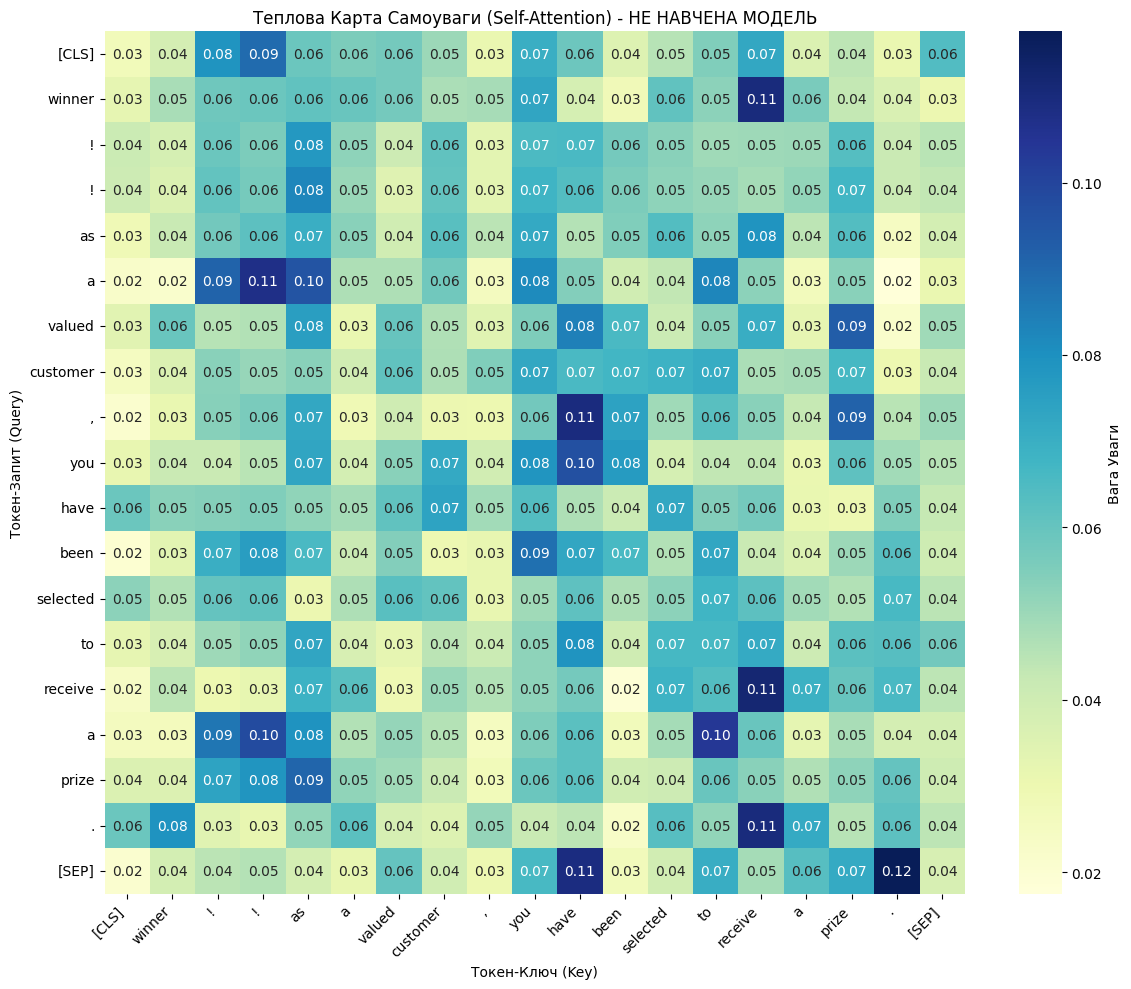

In [49]:
# Припускаємо, що всі змінні з попередніх кроків визначені:
# tokenizer, VOCAB_SIZE, D_MODEL, NHEAD, MAX_LEN
# Клас PositionalEncoding та клас TextClassificationDataset мають бути визначені

texts_demo = ["WINNER!! As a valued customer, you have been selected to receive a prize."]
labels_demo = [1]
demo_dataset = TextClassificationDataset(pd.Series(texts_demo), pd.Series(labels_demo), tokenizer, max_len=MAX_LEN)
demo_loader = DataLoader(demo_dataset, batch_size=1)
device = torch.device("cpu") # Для демо можна використовувати CPU

# 1. Ініціалізація ДЕМО-МОДЕЛІ
demo_model = DemoTransformerClassifier(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=NHEAD,
    max_len=MAX_LEN
).to(device)

# 2. Зчитування входу та токенізація
batch = next(iter(demo_loader))
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)

# Отримання списку токенів для візуалізації
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
# Обрізаємо PAD-токени для візуалізації
tokens = [t for t in tokens if t != '[PAD]']
input_ids_seq = input_ids[:, :len(tokens)]
attention_mask_seq = attention_mask[:, :len(tokens)]


# 3. Виконання прямого проходу та отримання ваг
# Оскільки модель не навчалася, ваги будуть випадковими, але механізм Self-Attention працює
with torch.no_grad():
    _, attention_weights_tensor = demo_model(input_ids_seq, attention_mask_seq)

# 4. Візуалізація
# Ваги мають розмірність (1, L, L), беремо перший елемент батчу
attention_weights_matrix = attention_weights_tensor[0].cpu().numpy()

print(f"Аналізоване речення: {texts_demo[0]}")
print(f"Токени: {tokens}")
plot_attention_map(tokens, attention_weights_matrix,
                   title="Теплова Карта Самоуваги (Self-Attention) - НЕ НАВЧЕНА МОДЕЛЬ")

## Приклад 2

--- КРОК 1: Токенізація ---
|   Позиція (Pos) | Токен       |   ID Токена | Тип Токена   |
|----------------:|:------------|------------:|:-------------|
|               0 | [CLS]       |         101 | [CLS]        |
|               1 | free        |        2489 | Subword/Word |
|               2 | entry       |        4443 | Subword/Word |
|               3 | in          |        1999 | Subword/Word |
|               4 | a           |        1037 | Subword/Word |
|               5 | weekly      |        4882 | Subword/Word |
|               6 | competition |        2971 | Subword/Word |
|               7 | !           |         999 | Subword/Word |
|               8 | [SEP]       |         102 | [SEP]        |

Маска Уваги (1 = враховувати): [1 1 1 1 1 1 1 1 1]
--------------------------------------------------
--- КРОК 2-3: Емббеддінг та Позиційне Кодування ---

Контекстуалізований Вхідний Вектор (Перші 3D)
|     Dim 1 |     Dim 2 |     Dim 3 | Токен       |
|----------:|----------:|

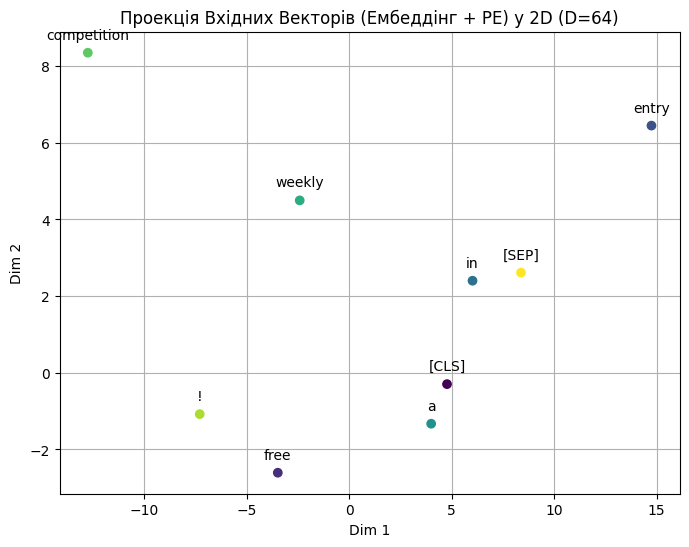

--------------------------------------------------
--- КРОК 4: Механізм Самоуваги (Self-Attention) ---


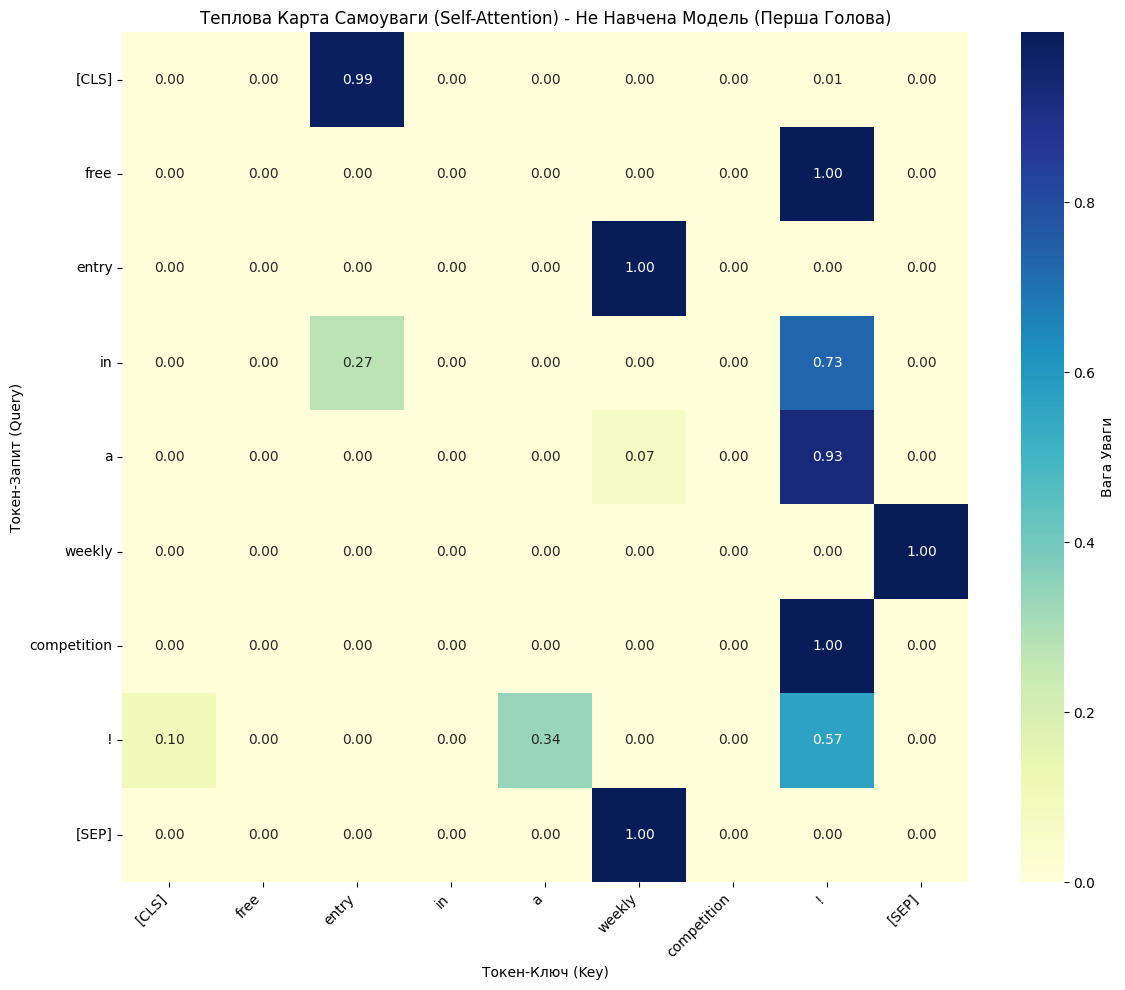

--------------------------------------------------
--- КРОК 5-6: Агрегація CLS та Фінальна Класифікація ---
Розмірність CLS-вектора (Агрегований контекст): (64,)

Фінальне передбачення:
| Клас        |   Логіт (Сира Оцінка) |   Ймовірність (Softmax) |
|:------------|----------------------:|------------------------:|
| Не спам (0) |               3.24482 |                0.606168 |
| Спам (1)    |               2.81359 |                0.393832 |

ПЕРЕДБАЧЕННЯ МОДЕЛІ (Не навчена): НЕ СПАМ


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import math
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# --- Ініціалізація (припускаємо, що ці класи вже визначені) ---
# Для запуску потрібні: PositionalEncoding, SimpleSelfAttentionWithWeights, DemoTransformerClassifier, TextClassificationDataset
# Я повторюю їх тут, щоб код був самодостатнім:

class PositionalEncoding(nn.Module):
    # ... (код PositionalEncoding) ...
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class SimpleSelfAttentionWithWeights(nn.Module):
    # ... (код SimpleSelfAttentionWithWeights) ...
    def __init__(self, d_model, nhead):
        super().__init__()
        self.head_dim = d_model // nhead
        self.nhead = nhead
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
    def forward(self, x, key_padding_mask=None):
        B, L, D = x.size()
        Q = self.q_proj(x).view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(B, L, D)
        output = self.out_proj(context)
        return output, attention_weights[:, 0, :, :] # Повертаємо ваги першої голови

class DemoTransformerClassifier(nn.Module):
    # ... (код DemoTransformerClassifier) ...
    def __init__(self, vocab_size, d_model=128, nhead=4, num_classes=2, max_len=64):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.attention_block = SimpleSelfAttentionWithWeights(d_model, nhead)
        self.classifier = nn.Linear(d_model, num_classes)
    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        key_padding_mask = attention_mask == 0 if attention_mask is not None else None
        out_att, weights = self.attention_block(x, key_padding_mask=key_padding_mask)
        cls_repr = out_att[:, 0, :]
        return self.classifier(cls_repr), weights

class TextClassificationDataset(Dataset):
    # ... (код TextClassificationDataset) ...
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx]); label = self.labels[idx]
        enc = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {"input_ids": enc["input_ids"].squeeze(0), "attention_mask": enc["attention_mask"].squeeze(0), "label": torch.tensor(label, dtype=torch.long)}

# --- Налаштування ---
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
VOCAB_SIZE = tokenizer.vocab_size
D_MODEL = 64 # Зменшимо розмірність для зручності
NHEAD = 4
MAX_LEN = 20

# --- Дані для демонстрації ---
demo_text = "Free entry in a weekly competition!"
demo_label = 1 # Spam
texts_demo = [demo_text]
labels_demo = [demo_label]

demo_dataset = TextClassificationDataset(pd.Series(texts_demo), pd.Series(labels_demo), tokenizer, max_len=MAX_LEN)
demo_loader = DataLoader(demo_dataset, batch_size=1)
batch = next(iter(demo_loader))
input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
device = torch.device("cpu") # Використовуємо CPU для демо

# Ініціалізація моделі (не навчена)
demo_model = DemoTransformerClassifier(vocab_size=VOCAB_SIZE, d_model=D_MODEL, nhead=NHEAD, max_len=MAX_LEN).to(device)

# --- 2. Візуалізація: Токени та Їхні ID ---
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
# Прибираємо [PAD] для відображення
actual_len = torch.sum(attention_mask[0]).item()
tokens_actual = tokens[:actual_len]
input_ids_actual = input_ids[0][:actual_len]

print("--- КРОК 1: Токенізація ---")
df_tokens = pd.DataFrame({
    'Позиція (Pos)': list(range(actual_len)),
    'Токен': tokens_actual,
    'ID Токена': input_ids_actual.numpy(),
    'Тип Токена': ['[CLS]' if i == 0 else '[SEP]' if i == actual_len - 1 else 'Subword/Word' for i in range(actual_len)]
})
print(df_tokens.to_markdown(index=False))
print(f"\nМаска Уваги (1 = враховувати): {attention_mask[0].numpy()[:actual_len]}")
print("-" * 50)


# --- 3. Прямий Прохід для Візуалізації Векторів ---
with torch.no_grad():
    # 3.1. Емббеддінг (Крок 2)
    word_embeddings = demo_model.embedding(input_ids_actual.unsqueeze(0)) * math.sqrt(demo_model.d_model)

    # 3.2. Додавання Позиційного Кодування (Крок 3)
    input_to_attention = demo_model.positional_encoding(word_embeddings)

    # 3.3. Шари Уваги (Крок 4)
    _, attention_weights_tensor = demo_model.attention_block(
        input_to_attention,
        key_padding_mask=attention_mask[:, :actual_len] == 0
    )

    # 3.4. Вихід CLS та Класифікація (Крок 5 & 6)
    cls_repr = input_to_attention[:, 0, :] # У цьому демо візьмемо вектор після PE

    # Фінальний Logits
    logits = demo_model.classifier(cls_repr)
    probabilities = F.softmax(logits, dim=-1)

# --- КРОК 2: Емббеддінг та Позиційне Кодування (Концептуальна Візуалізація) ---

print("--- КРОК 2-3: Емббеддінг та Позиційне Кодування ---")

# Візуалізуємо 2D-проекцію векторів (за допомогою PCA/UMAP це можливо)
# Тут ми покажемо лише перші 3 розмірності
df_embedding = pd.DataFrame(
    input_to_attention.squeeze(0).cpu().numpy()[:actual_len, :3],
    columns=['Dim 1', 'Dim 2', 'Dim 3']
)
df_embedding['Токен'] = tokens_actual

print("\nКонтекстуалізований Вхідний Вектор (Перші 3D)")
print(df_embedding.to_markdown(index=False))

plt.figure(figsize=(8, 6))
plt.scatter(df_embedding['Dim 1'], df_embedding['Dim 2'], c=df_embedding.index, cmap='viridis')
for i, txt in enumerate(tokens_actual):
    plt.annotate(txt, (df_embedding['Dim 1'][i], df_embedding['Dim 2'][i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title(f'Проекція Вхідних Векторів (Ембеддінг + PE) у 2D (D={D_MODEL})')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.show()

print("-" * 50)

# --- КРОК 4: Теплова Карта Самоуваги (Self-Attention) ---

print("--- КРОК 4: Механізм Самоуваги (Self-Attention) ---")

attention_weights_matrix = attention_weights_tensor[0].cpu().numpy()[:actual_len, :actual_len]

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    attention_weights_matrix,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    xticklabels=tokens_actual,
    yticklabels=tokens_actual,
    cbar_kws={'label': 'Вага Уваги'}
)

ax.set_xticklabels(tokens_actual, rotation=45, ha='right')
ax.set_yticklabels(tokens_actual, rotation=0)

plt.title("Теплова Карта Самоуваги (Self-Attention) - Не Навчена Модель (Перша Голова)")
plt.xlabel("Токен-Ключ (Key)")
plt.ylabel("Токен-Запит (Query)")
plt.tight_layout()
plt.show()

print("-" * 50)

# --- КРОК 5 & 6: Фінальна Класифікація ---

print("--- КРОК 5-6: Агрегація CLS та Фінальна Класифікація ---")

# Вихід CLS-токена
cls_output = cls_repr[0].cpu().numpy()

print(f"Розмірність CLS-вектора (Агрегований контекст): {cls_output.shape}")

df_result = pd.DataFrame({
    'Клас': ['Не спам (0)', 'Спам (1)'],
    'Логіт (Сира Оцінка)': logits.squeeze().cpu().numpy(),
    'Ймовірність (Softmax)': probabilities.squeeze().cpu().numpy()
})

print("\nФінальне передбачення:")
print(df_result.to_markdown(index=False))

predicted_class = torch.argmax(logits, dim=1).item()
final_prediction = "СПАМ" if predicted_class == 1 else "НЕ СПАМ"

print(f"\nПЕРЕДБАЧЕННЯ МОДЕЛІ (Не навчена): {final_prediction}")

# **Варіант 2**
*Продовження текстової послідовності (наприклад, cat sat -> on the mat).*

### **Дані**
• Використати будь-який текстовий датасет на вибір.

### **Реалізація**

•	Токенізація: простий split або стандартний BPE токенайзер HuggingFace.

•	Архітектура моделі: Embedding + позиційне кодування + 1-5 шарів TransformerDecoderLayer + Linear.

•	Метрика: Perplexity, BLEU, ROUGE-L.

•	Збереження моделі у файл.

•	Тюнінг гіперпараметрів (nhead, d_model).
